In [14]:
import datetime
import matplotlib.pyplot as plt
import numpy as np
import numpyro
import pyro
from sklearn.datasets import make_blobs
from sklearn.mixture import GaussianMixture
import seaborn as sns
import pandas as pd
import corner
import scipy.stats as stats
from tqdm import tqdm
import torch

from msc.plot_utils import set_size
from msc.config_utils import config

from msc import config
from msc.data_utils import get_dataset
from msc.plot_utils import set_size
from msc.prior_utils import get_events_df, vm_density, vm_mixture

plt.style.use(['science', 'no-latex'])
plt.viridis()


SEC = 1e6
MIN = 60 * SEC
HOUR = 60 * MIN

%load_ext autoreload



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<Figure size 252x189 with 0 Axes>

In [15]:
# define number of bins
N = 24
# get dataset
ds = get_dataset(config['dataset_id'])
# get dataset's start time
start_time = datetime.datetime.fromtimestamp(ds.start_time / SEC, datetime.timezone.utc)
# get dataset's seizure annotations
seizures = ds.get_annotations('seizures')
# convert annotations to event datetimes
events = [start_time + datetime.timedelta(microseconds=seizure.start_time_offset_usec) for seizure in seizures]
# create events_df
events_df = get_events_df(events)
# compute events circadian histogram
circadian_hist = pd.cut(events_df.hour, N, labels=range(N)).value_counts().sort_index()

width = 478  #pt



In [31]:
from functools import partial

def vm_mixture(x, circadian_hist): 
    mus = np.arange(24) + 0.5
    density_func = lambda x: sum([circadian_hist[i] * partial(vm_density, mu=mu)(x) for i, mu in enumerate(mus)])  # not normalized
    normalizing_constant = np.trapz(1/density_func(np.linspace(0, 24, 100)))
    return 1 / (normalizing_constant * density_func(x))


In [32]:
X = np.linspace(0, 24, 100)
y = vm_mixture(X, circadian_hist)

In [33]:
np.trapz(y)

1.0

(0.0, 0.015)

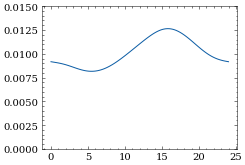

In [34]:
plt.plot(X, y)
plt.ylim(0, 0.015)

<BarContainer object of 24 artists>

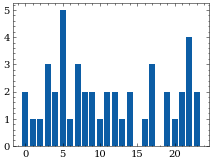

In [36]:
plt.bar(np.arange(24), circadian_hist)

In [ ]:


true_intensity_function = lambda times: torch.cos(times * 2 * np.pi).add(1).mul(intensity_max / 2.)

max_time = 2

times = torch.linspace(0, max_time, 128)
num_samples = int(pyro.distributions.Poisson(true_intensity_function(times).mean() * max_time).sample().item())
print(f"Number of sampled arrivals: {num_samples}")


def log_prob_accept(val):
    intensities = true_intensity_function(val)
    res = torch.log(intensities / (true_intensity_function(times).mean() * max_time))
    return res